In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, Dropout, Flatten, Dense, LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve, precision_score,classification_report

In [2]:
df = pd.read_csv("C:/Users/sehsa/Downloads/df_continous.csv")
df.drop("Close", axis=1, inplace=True)
df.head()

,Target,btc_dom,sma_2,sma_3,sma_4,sma_5,sma_6,sma_8,sma_12,sma_16,...,cci_6,cci_8,cci_12,ado,eth_MACD,eth_MACD_signal,eth_MACD_hist,eth_STOCHk_14_3_3,eth_STOCHd_14_3_3,eth_Williams_%R
0,0,54.39109,296.530,296.4225,296.750000,295.930,295.565000,293.94500,294.156667,296.180625,...,2.875399,32.319410,22.875017,493.378047,-2.627344,-2.940150,0.312807,53.412335,49.021066,-51.867220
1,1,54.39109,292.545,295.5300,294.976667,295.512,295.253333,293.94500,293.545000,295.143125,...,-71.052007,-2.230640,2.851062,450.385447,-2.752230,-2.902566,0.150336,52.045861,52.196828,-53.814793
2,0,54.39109,292.550,294.5400,292.773333,295.070,295.131667,294.81125,293.353333,294.518750,...,-35.178876,11.882980,46.039872,427.232234,-2.710221,-2.864097,0.153876,49.474662,51.644286,-45.894001
3,1,54.39109,291.125,291.8350,291.373333,293.436,294.061667,294.22125,293.292500,293.925000,...,-144.128788,-141.125863,-61.206078,382.210034,-2.982263,-2.887730,-0.094533,44.040260,48.520261,-68.170426
4,0,54.39109,289.590,291.0700,290.803333,291.500,292.890000,293.74625,292.986667,293.385000,...,-116.912347,-143.861874,-87.968012,407.012559,-3.070475,-2.924279,-0.146196,41.636001,45.050308,-61.027569


In [3]:
split_index = int(len(df) * 0.8)  # %80 train, %20 test
data_training = df.loc[:split_index - 1, :].copy()   #  %80
data_testing = df.loc[split_index:, :].copy()  #  %20

feature_columns = df.columns.drop('Target')  # 'Target' dışındaki sütunlar özellik
X_train = data_training[feature_columns].values  # Eğitim verisi özellikleri
y_train = data_training['Target'].values  # Eğitim verisi hedef değişkeni
X_test = data_testing[feature_columns].values  # Test verisi özellikleri
y_test = data_testing['Target'].values  # Test verisi hedef değişkeni

# MinMaxScaler ile ölçeklendirme
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

validation_size = int(len(X_train_scaled) * 0.1)  # Eğitim verisinin %10'u doğrulama için
X_val_scaled = X_train_scaled[-validation_size:]  # Son %10 doğrulama verisi
y_val = y_train[-validation_size:]  # Son %10 hedef değişken
X_train_scaled = X_train_scaled[:-validation_size]  # İlk %90 eğitim verisi
y_train = y_train[:-validation_size]  # İlk %90 hedef değişken

# Zaman serisi formatına dönüştürme
def create_sequences(data, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(target[i+window_size])
    return np.array(X), np.array(y)

# Zaman penceresi boyutu
window_size = 15

# Eğitim ve test verilerini zaman serisi formatına dönüştürme
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, window_size)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, window_size)


In [4]:
# Display shapes of the datasets
X_train_seq.shape, X_val_seq.shape, X_test_seq.shape, y_train_seq.shape, y_val_seq.shape, y_test_seq.shape

((36354, 15, 44), (4026, 15, 44), (10088, 15, 44), (36354,), (4026,), (10088,))

I am testing how the model in the article performs on my own dataset.
Selected CLSTM neural network architecture with five Convolutional layers plus a single LSTM layer and 8 fully connected MLP as output ( Dense layers) for output.

In [21]:
# Sequential Model
model = Sequential()

# Block 1
model.add(Conv1D(filters=64, kernel_size=1, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.25))

# Block 2
model.add(Conv1D(filters=32, kernel_size=1))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.25))

# Block 3 (repeated twice)
for _ in range(2):
    model.add(Conv1D(filters=8, kernel_size=1))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.25))

# Block 4
model.add(Conv1D(filters=1, kernel_size=1))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.25))

# LSTM Layer
model.add(LSTM(150, return_sequences=False))
model.add(BatchNormalization())
model.add(ReLU())

# Fully Connected Layers
model.add(Dense(200, activation='relu'))
for _ in range(6):
    model.add(Dense(100, activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)


# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)
# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.5038 - loss: 0.6932 - val_accuracy: 0.5060 - val_loss: 0.6933
Epoch 2/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5069 - loss: 0.6932 - val_accuracy: 0.5057 - val_loss: 0.6930
Epoch 3/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.5048 - loss: 0.6931 - val_accuracy: 0.5060 - val_loss: 0.6948
Epoch 4/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.5071 - loss: 0.6931 - val_accuracy: 0.5060 - val_loss: 0.6932
Epoch 5/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.5062 - loss: 0.6931 - val_accuracy: 0.5060 - val_loss: 0.6931
Epoch 6/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.5103 - loss: 0.6930 - val_accuracy: 0.5035 - val_loss: 0.6931
Epoch 7/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.5040 - loss: 0.6931 - val_accuracy: 0.5060 - val_loss: 0.6931
Epoch 8/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_20 (Conv1D)              │ (None, 15, 64)         │         2,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_21 (ReLU)                 │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 15, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 15, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 15, 8)          │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 15, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_23 (ReLU)                 │ (None, 15, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 15, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 15, 8)          │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 15, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 15, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 15, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 15, 1)          │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 15, 1)          │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_25 (ReLU)                 │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 150)            │           600 │
│ (BatchNormalization)            │                        │             

 Total params: 594,324 (2.27 MB)

 Trainable params: 197,932 (773.17 KB)

 Non-trainable params: 526 (2.05 KB)

 Optimizer params: 395,866 (1.51 MB)

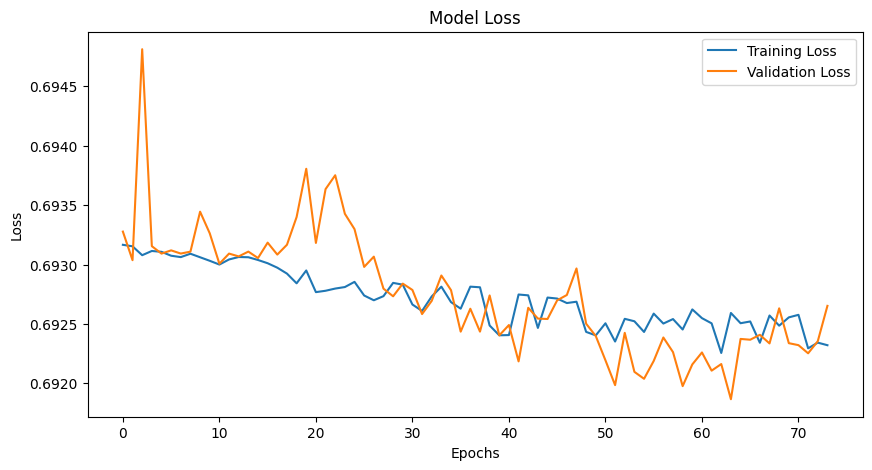

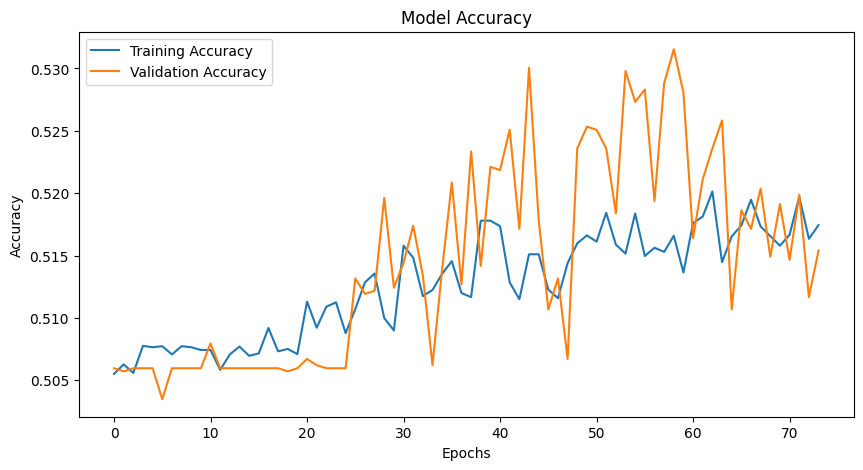

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 0.5189
              precision    recall  f1-score   support

           0       0.54      0.34      0.42      5115
           1       0.51      0.70      0.59      4973

    accuracy                           0.52     10088
   macro avg       0.52      0.52      0.50     10088
weighted avg       0.52      0.52      0.50     10088

ROC-AUC Score: 0.5260


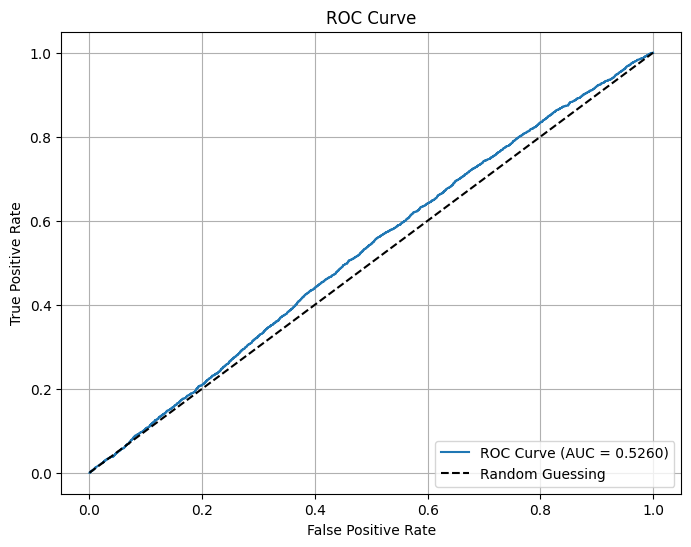

In [22]:
model.summary()

# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

The learning rate (0.0001) might be too low. Therefore, I will try to improve my learning rate using the following methods:
ReduceLROnPlateau: Reduces the learning rate when the model's validation loss/performance does not improve during training.
LearningRateScheduler: Adjusts the learning rate according to a predefined schedule during the training process.
Finally, I will manually experiment with a different learning rate(0.001).

In [6]:
# Öğrenme oranı için bir fonksiyon tanımlayın
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.1
    else:
        return lr * 0.01

# LearningRateScheduler callback tanımlanıyor
lr_scheduler = LearningRateScheduler(scheduler)
optimizer = Adam(learning_rate=0.01)

# Modeli yeniden eğit
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,               # Epoch sayısı
    batch_size=32,           # Batch boyutu
    callbacks=[early_stopping, lr_scheduler],  # LearningRateScheduler dahil edildi
    verbose=1
)
# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5095 - loss: 0.6930 - val_accuracy: 0.5060 - val_loss: 0.6931 - learning_rate: 1.0000e-15
Epoch 2/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5064 - loss: 0.6931 - val_accuracy: 0.5060 - val_loss: 0.6931 - learning_rate: 1.0000e-15
Epoch 3/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5088 - loss: 0.6930 - val_accuracy: 0.5060 - val_loss: 0.6931 - learning_rate: 1.0000e-15
Epoch 4/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.5072 - loss: 0.6931 - val_accuracy: 0.5060 - val_loss: 0.6931 - learning_rate: 1.0000e-15
Epoch 5/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.5045 - loss: 0.6932 - val_accuracy: 0.5060 - val_loss: 0.6931 - learning_rate: 1.0000e-15
Epoch 6/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5106 - loss: 0.6929 - val_accuracy: 0.5060 - val_loss: 0.6931 - learning_rate: 1.0000e-15
Epoch 7/100
1137/1137 ━━━━━━━━━━━━

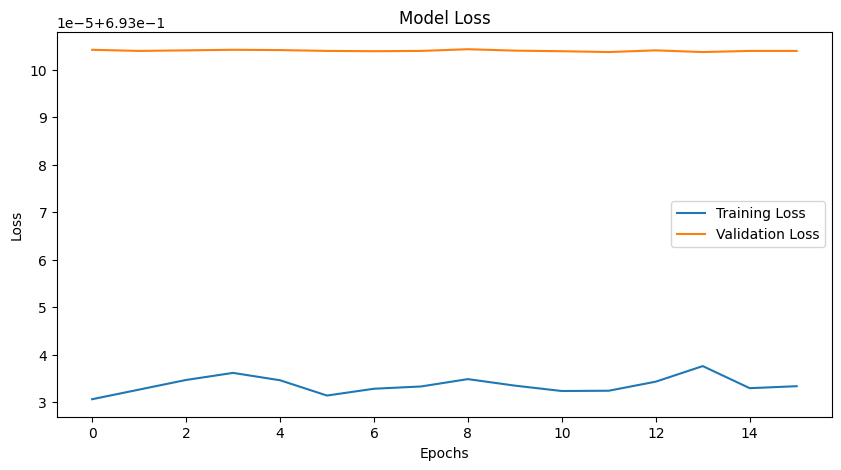

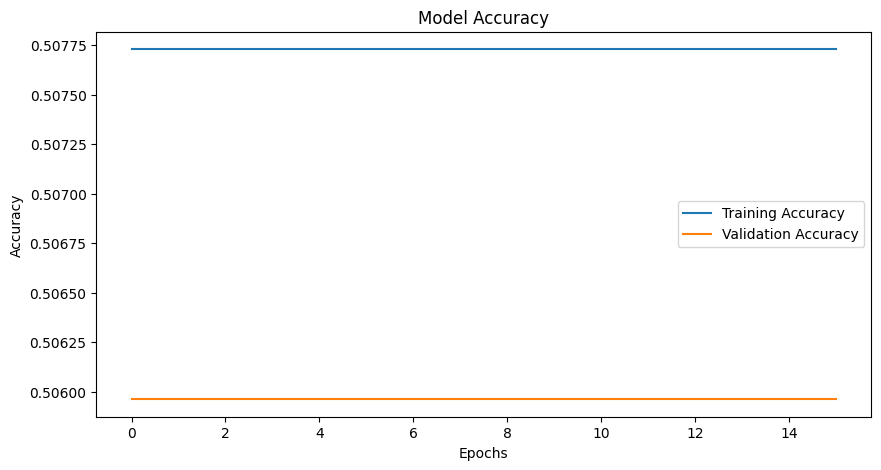

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 0.4930
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5115
           1       0.49      1.00      0.66      4973

    accuracy                           0.49     10088
   macro avg       0.25      0.50      0.33     10088
weighted avg       0.24      0.49      0.33     10088

ROC-AUC Score: 0.5088


c:\Users\sehsa\ETH\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sehsa\ETH\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sehsa\ETH\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


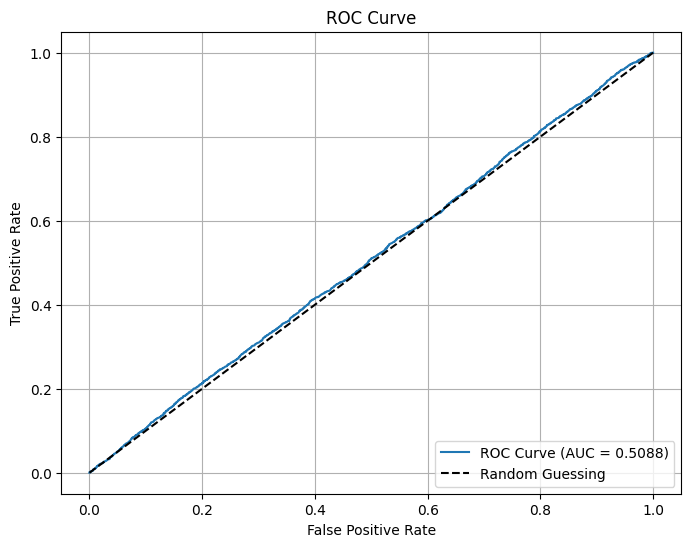

In [7]:
# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [8]:
optimizer = Adam(learning_rate=0.001)

# ReduceLROnPlateau callback tanımlanıyor
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Doğrulama kaybına göre ayar yap
    factor=0.5,            # Öğrenme oranını %50 azalt
    patience=5,            # İyileşme olmazsa 5 epoch bekle
    min_lr=1e-6            # Minimum öğrenme oranı
)

# Modeli yeniden eğit
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,               # Epoch sayısı
    batch_size=32,           # Batch boyutu
    callbacks=[early_stopping, reduce_lr],  # ReduceLROnPlateau dahil edildi
    verbose=1
)
# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5065 - loss: 0.6931 - val_accuracy: 0.5060 - val_loss: 0.6931 - learning_rate: 1.0000e-21
Epoch 2/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5061 - loss: 0.6931 - val_accuracy: 0.5060 - val_loss: 0.6931 - learning_rate: 1.0000e-21
Epoch 3/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5051 - loss: 0.6931 - val_accuracy: 0.5060 - val_loss: 0.6931 - learning_rate: 1.0000e-21
Epoch 4/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.5073 - loss: 0.6930 - val_accuracy: 0.5060 - val_loss: 0.6931 - learning_rate: 1.0000e-21
Epoch 5/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5042 - loss: 0.6932 - val_accuracy: 0.5060 - val_loss: 0.6931 - learning_rate: 1.0000e-21
Epoch 6/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5107 - loss: 0.6929 - val_accuracy: 0.5060 - val_loss: 0.6931 - learning_rate: 1.0000e-21
Epoch 7/100
1137/1137 ━━━━━━━━━━━━

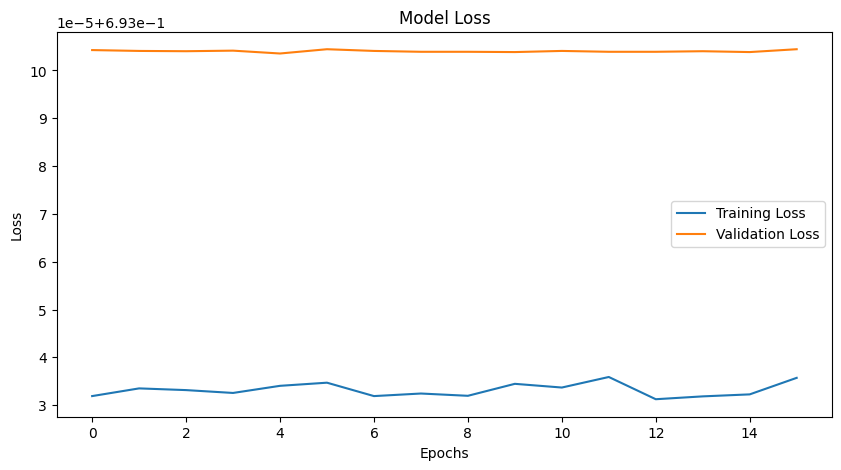

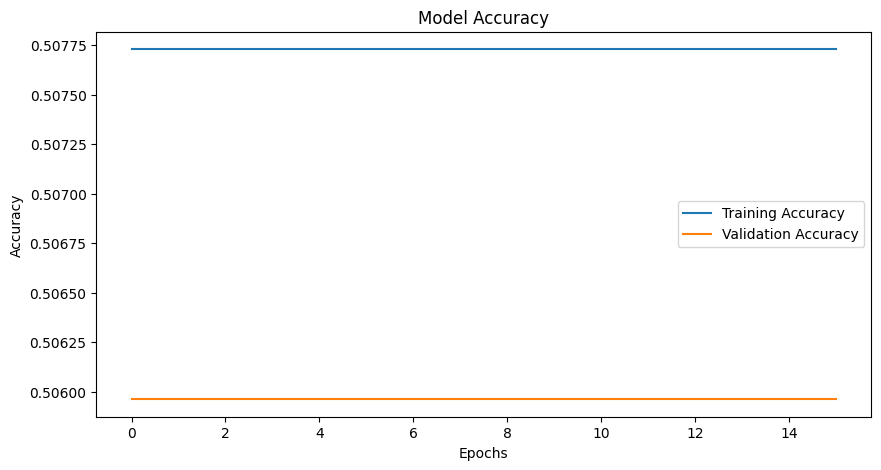

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.4930
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5115
           1       0.49      1.00      0.66      4973

    accuracy                           0.49     10088
   macro avg       0.25      0.50      0.33     10088
weighted avg       0.24      0.49      0.33     10088

ROC-AUC Score: 0.5066


c:\Users\sehsa\ETH\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sehsa\ETH\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sehsa\ETH\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


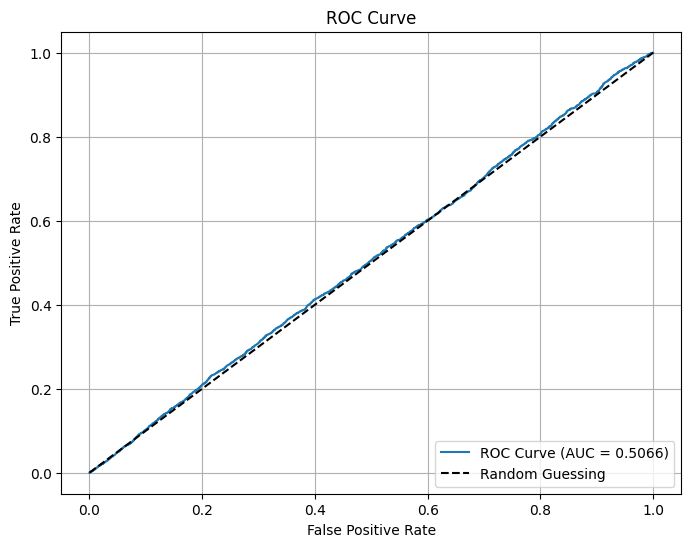

In [9]:
# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [10]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)


# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)
# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.5022 - loss: 0.6933 - val_accuracy: 0.5060 - val_loss: 0.6931
Epoch 2/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5075 - loss: 0.6931 - val_accuracy: 0.5060 - val_loss: 0.6931
Epoch 3/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5086 - loss: 0.6930 - val_accuracy: 0.5060 - val_loss: 0.6931
Epoch 4/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5091 - loss: 0.6930 - val_accuracy: 0.5060 - val_loss: 0.6931
Epoch 5/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5087 - loss: 0.6930 - val_accuracy: 0.5060 - val_loss: 0.6931
Epoch 6/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5081 - loss: 0.6930 - val_accuracy: 0.5060 - val_loss: 0.6931
Epoch 7/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5031 - loss: 0.6932 - val_accuracy: 0.5060 - val_loss: 0.6931
Epoch 8/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 

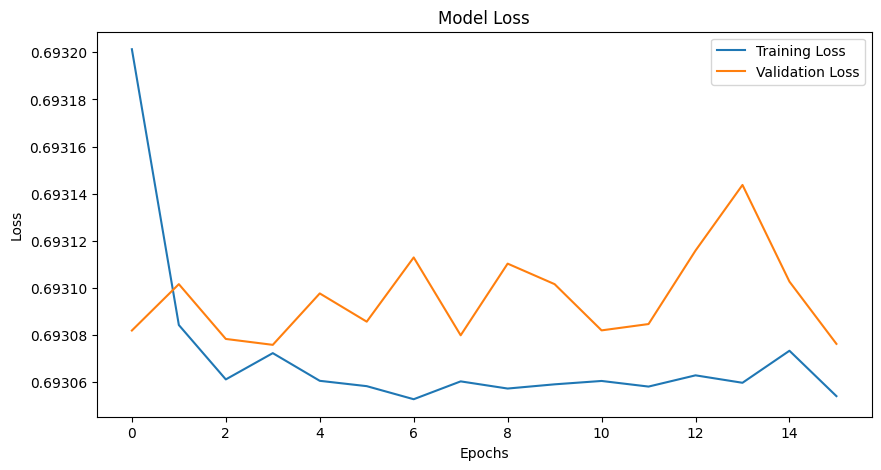

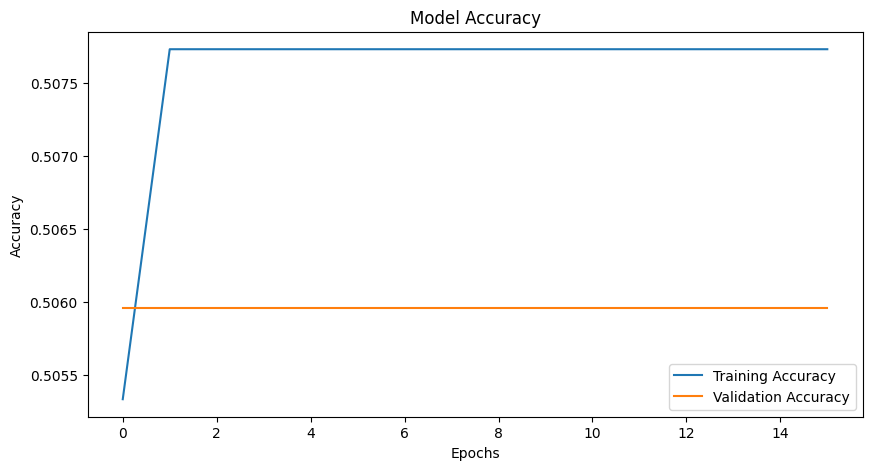

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 0.4930
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5115
           1       0.49      1.00      0.66      4973

    accuracy                           0.49     10088
   macro avg       0.25      0.50      0.33     10088
weighted avg       0.24      0.49      0.33     10088

ROC-AUC Score: 0.4825


c:\Users\sehsa\ETH\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sehsa\ETH\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sehsa\ETH\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


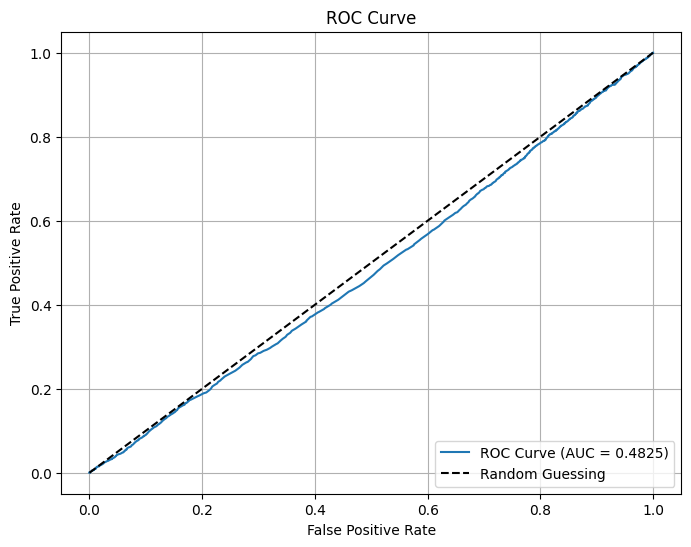

In [11]:
# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Based on the results above, I couldn't reach a meaningful conclusion by changing the learning rate. Therefore, in my subsequent experiments, the learning rate for the Adam optimizer will remain at 0.0001. Now, I am trying a different optimizer.

Stochastic Gradient Descent (SGD) is a method used to find the minimum of a function. Its goal is to minimize the loss function by optimizing its parameters step by step.

In [24]:
# SGD optimizatörünü tanımla
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

# Modeli yeniden derle
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# Modeli eğit
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,               # Epoch sayısı
    batch_size=32,           # Batch boyutu
    callbacks=[early_stopping],  # EarlyStopping kullanılabilir
    verbose=1
)
# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.5137 - loss: 0.6928 - val_accuracy: 0.5087 - val_loss: 0.6925
Epoch 2/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.5154 - loss: 0.6926 - val_accuracy: 0.5209 - val_loss: 0.6923
Epoch 3/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5148 - loss: 0.6927 - val_accuracy: 0.5325 - val_loss: 0.6921
Epoch 4/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.5139 - loss: 0.6927 - val_accuracy: 0.5348 - val_loss: 0.6922
Epoch 5/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.5182 - loss: 0.6926 - val_accuracy: 0.5216 - val_loss: 0.6922
Epoch 6/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.5138 - loss: 0.6927 - val_accuracy: 0.5291 - val_loss: 0.6921
Epoch 7/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5171 - loss: 0.6925 - val_accuracy: 0.5079 - val_loss: 0.6927
Epoch 8/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 

In [29]:
# SGD optimizatörünü tanımla
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Modeli derle
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# Modeli eğit
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.5129 - loss: 0.6928 - val_accuracy: 0.5268 - val_loss: 0.6922 - learning_rate: 0.0100
Epoch 2/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5092 - loss: 0.6932 - val_accuracy: 0.5124 - val_loss: 0.6926 - learning_rate: 0.0100
Epoch 3/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5196 - loss: 0.6924 - val_accuracy: 0.5323 - val_loss: 0.6921 - learning_rate: 0.0100
Epoch 4/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5111 - loss: 0.6930 - val_accuracy: 0.5060 - val_loss: 0.6933 - learning_rate: 0.0100
Epoch 5/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5157 - loss: 0.6924 - val_accuracy: 0.5301 - val_loss: 0.6922 - learning_rate: 0.0100
Epoch 6/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5172 - loss: 0.6926 - val_accuracy: 0.5109 - val_loss: 0.6926 - learning_rate: 0.0100
Epoch 7/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step -

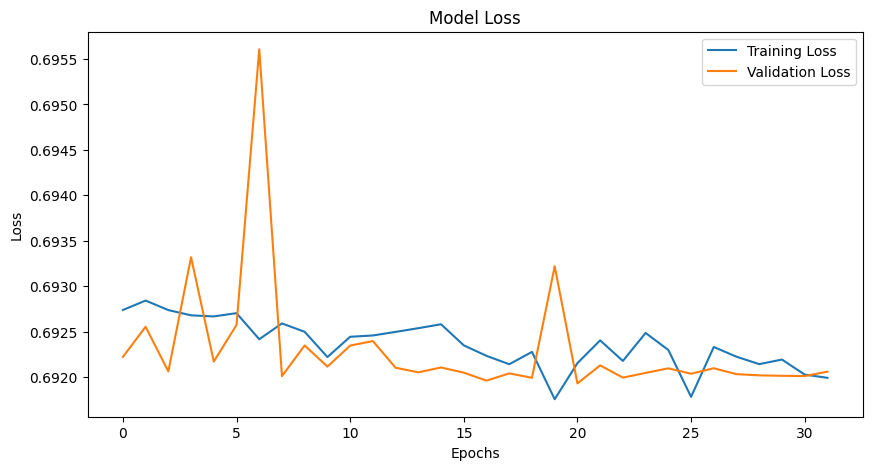

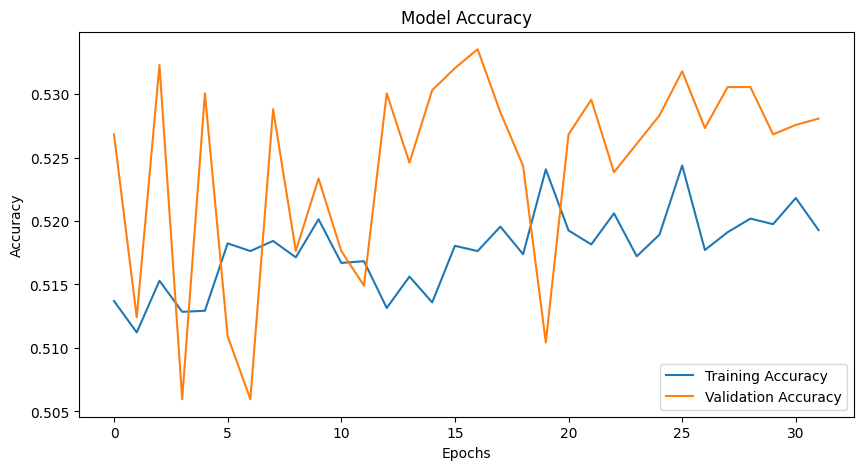

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 0.5116
              precision    recall  f1-score   support

           0       0.55      0.21      0.30      5115
           1       0.50      0.82      0.62      4973

    accuracy                           0.51     10088
   macro avg       0.53      0.52      0.46     10088
weighted avg       0.53      0.51      0.46     10088

ROC-AUC Score: 0.5225


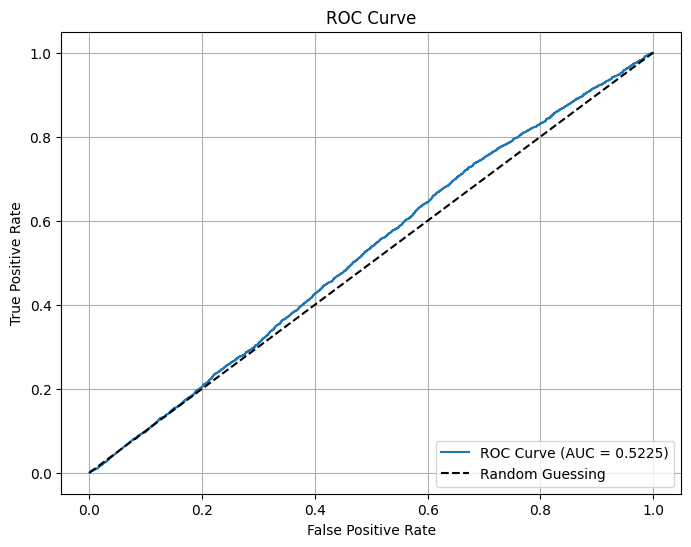

In [30]:
# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Now, I will test on a simpler model by removing some layers.
I reduced the number of blocks, the Conv1D layers, the LSTM layers, and the number of fully connected layers.

In [5]:
# Sequential Model
model = Sequential()

# Block 1
model.add(Conv1D(filters=64, kernel_size=1, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.25))

# Block 2
model.add(Conv1D(filters=32, kernel_size=1))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.25))

# LSTM Layer
model.add(LSTM(150, return_sequences=False))
model.add(BatchNormalization())
model.add(ReLU())

# Fully Connected Layers
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.5089 - loss: 0.7200 - val_accuracy: 0.5094 - val_loss: 0.6976
Epoch 2/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5048 - loss: 0.7043 - val_accuracy: 0.5102 - val_loss: 0.7056
Epoch 3/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5060 - loss: 0.6981 - val_accuracy: 0.5107 - val_loss: 0.6963
Epoch 4/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5144 - loss: 0.6945 - val_accuracy: 0.5077 - val_loss: 0.6942
Epoch 5/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5150 - loss: 0.6944 - val_accuracy: 0.5087 - val_loss: 0.6945
Epoch 6/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5098 - loss: 0.6938 - val_accuracy: 0.5070 - val_loss: 0.6943
Epoch 7/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5248 - loss: 0.6923 - val_accuracy: 0.5179 - val_loss: 0.6919
Epoch 8/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5222

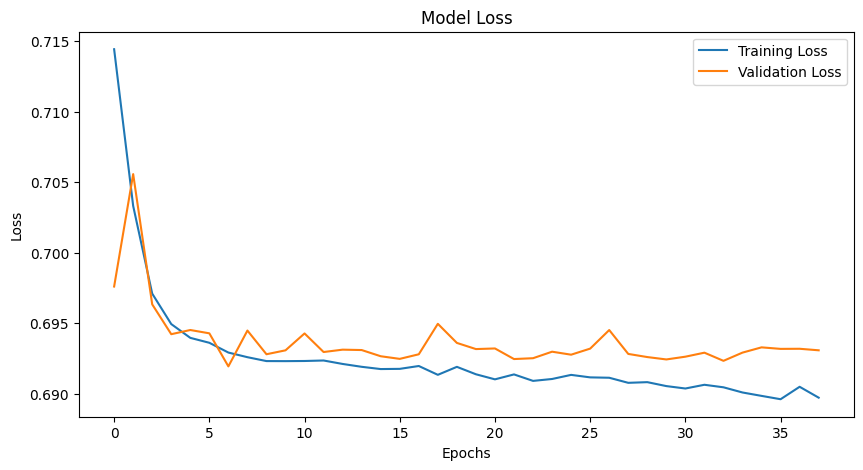

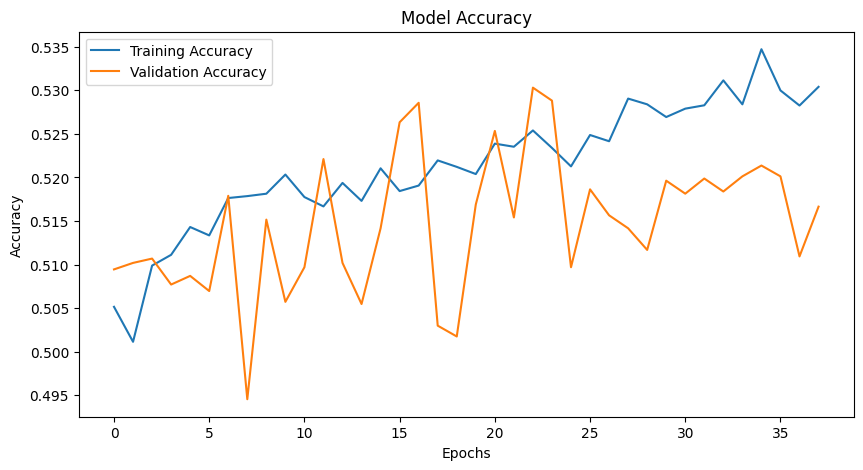

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.5054
              precision    recall  f1-score   support

           0       0.56      0.11      0.19      5115
           1       0.50      0.91      0.64      4973

    accuracy                           0.51     10088
   macro avg       0.53      0.51      0.42     10088
weighted avg       0.53      0.51      0.41     10088

ROC-AUC Score: 0.5335


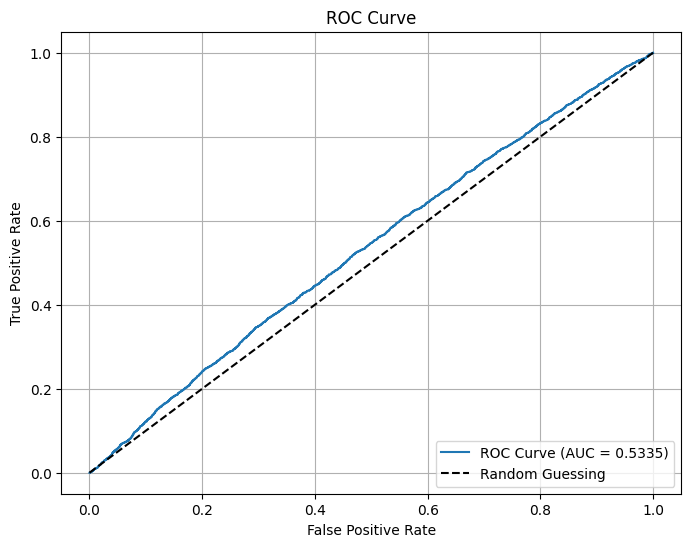

In [7]:

# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

After simplifying the model, I couldn't achieve good learning. To improve it, I am using a learning rate schedule and increased the kernel size to 3.
As a result, the following changes occurred in my model:
Increased Receptive Field of Filters: A larger kernel processes more neighboring features at once and learns a broader context.
Increase in Parameters and Computational Cost: Increasing the kernel size raises the number of parameters to learn in a Conv1D/Conv2D layer. This is calculated as input_channels * 3.

In [9]:
# Modeli yeniden tanımlama (basitleştirilmiş yapı)
model_simplified = Sequential()

# Block 1
model_simplified.add(Conv1D(filters=64, kernel_size=3, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model_simplified.add(BatchNormalization())
model_simplified.add(ReLU())
model_simplified.add(Dropout(0.3)) 

# Block 2
model_simplified.add(Conv1D(filters=32, kernel_size=3))
model_simplified.add(BatchNormalization())
model_simplified.add(ReLU())
model_simplified.add(Dropout(0.3))

# Block 3
model_simplified.add(Conv1D(filters=16, kernel_size=3))
model_simplified.add(BatchNormalization())
model_simplified.add(ReLU())
model_simplified.add(Dropout(0.3))

# LSTM Layer
model_simplified.add(LSTM(100, return_sequences=False))  # Daha az LSTM nöronu
model_simplified.add(BatchNormalization())

# Fully Connected Layers
model_simplified.add(Dense(100, activation='relu'))  # İlk dense katman 100 nöron
model_simplified.add(Dropout(0.3))  # Ek dropout
model_simplified.add(Dense(1, activation='sigmoid'))  # Çıkış katmanı


# Exponential Decay ile öğrenme oranı tanımlama
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,  # Başlangıç öğrenme oranı
    decay_steps=10000,            # Her 10.000 adımdan sonra
    decay_rate=0.9                # Öğrenme oranını %10 azalt
)

# Adam optimizatörüyle kullanımı
optimizer = Adam(learning_rate=lr_schedule)

# Modeli derleme
model_simplified.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# Modeli eğitme
history = model_simplified.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=200,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

# Test seti üzerinde değerlendirme
test_loss, test_accuracy = model_simplified.evaluate(X_test_seq, y_test_seq, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")



c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.5030 - loss: 0.7350 - val_accuracy: 0.4945 - val_loss: 0.7305
Epoch 2/200
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5009 - loss: 0.6958 - val_accuracy: 0.5060 - val_loss: 0.6936
Epoch 3/200
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5051 - loss: 0.6940 - val_accuracy: 0.5060 - val_loss: 0.6934
Epoch 4/200
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5105 - loss: 0.6934 - val_accuracy: 0.5060 - val_loss: 0.6930
Epoch 5/200
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5102 - loss: 0.6932 - val_accuracy: 0.5104 - val_loss: 0.6930
Epoch 6/200
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.5064 - loss: 0.6931 - val_accuracy: 0.5060 - val_loss: 0.6931
Epoch 7/200
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5137 - loss: 0.6929 - val_accuracy: 0.5060 - val_loss: 0.6929
Epoch 8/200
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5048 -

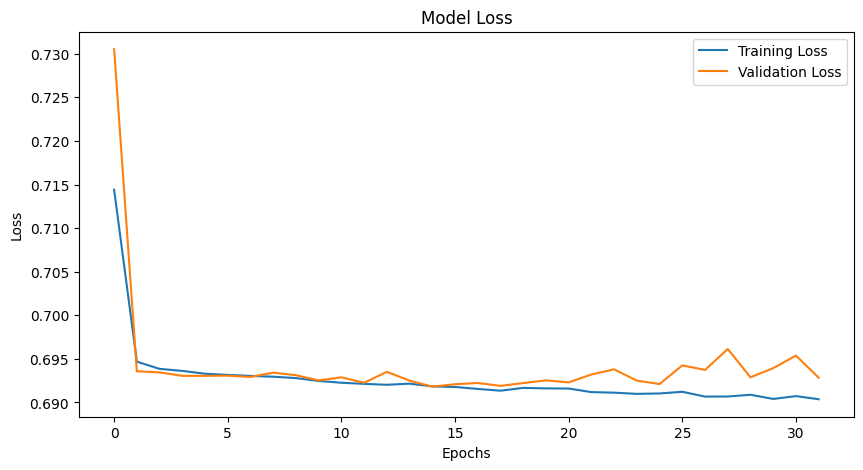

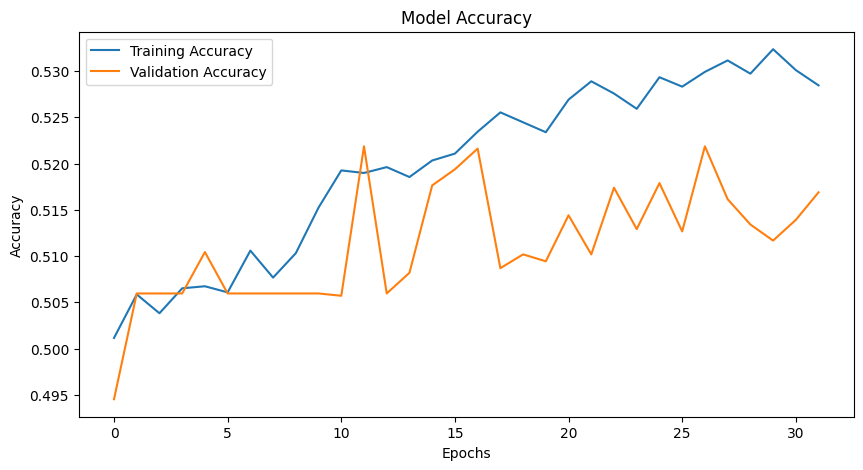

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.5201
              precision    recall  f1-score   support

           0       0.54      0.38      0.45      5115
           1       0.51      0.66      0.58      4973

    accuracy                           0.52     10088
   macro avg       0.52      0.52      0.51     10088
weighted avg       0.52      0.52      0.51     10088

ROC-AUC Score: 0.5404


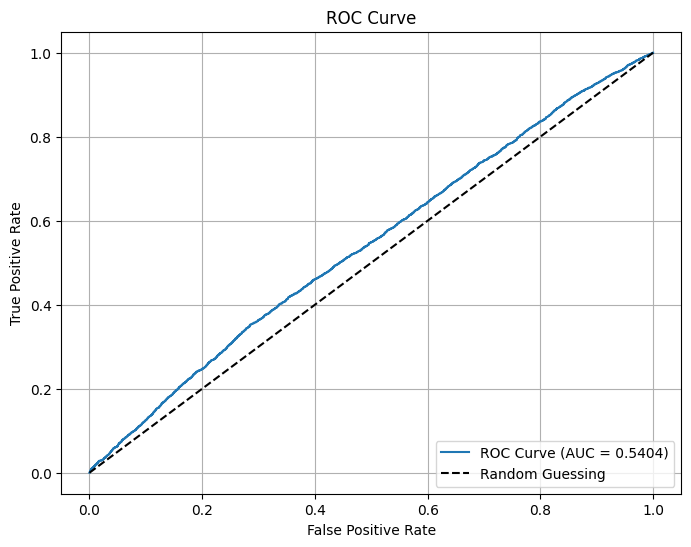

In [11]:

# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model_simplified.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

I am testing with a fixed learning rate.

In [6]:
# Modeli yeniden tanımlama (basitleştirilmiş yapı)
model_simplified = Sequential()

# Block 1
model_simplified.add(Conv1D(filters=64, kernel_size=3, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model_simplified.add(BatchNormalization())
model_simplified.add(ReLU())
model_simplified.add(Dropout(0.3))  # Dropout oranını artırdık

# Block 2
model_simplified.add(Conv1D(filters=32, kernel_size=3))
model_simplified.add(BatchNormalization())
model_simplified.add(ReLU())
model_simplified.add(Dropout(0.3))

# Block 3
model_simplified.add(Conv1D(filters=16, kernel_size=3))
model_simplified.add(BatchNormalization())
model_simplified.add(ReLU())
model_simplified.add(Dropout(0.3))

# LSTM Layer
model_simplified.add(LSTM(100, return_sequences=False))  # Daha az LSTM nöronu
model_simplified.add(BatchNormalization())

# Fully Connected Layers
model_simplified.add(Dense(100, activation='relu'))  # İlk dense katman 100 nöron
model_simplified.add(Dropout(0.3))  # Ek dropout
model_simplified.add(Dense(1, activation='sigmoid'))  # Çıkış katmanı

# Modeli derleme
optimizer = Adam(learning_rate=0.0001)
model_simplified.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Model özetini kontrol etme
model_simplified.summary()

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Modeli eğitme
history = model_simplified.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating the model
loss, accuracy = model_simplified.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 13, 64)         │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 13, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 11, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 11, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 9, 16)          │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 9, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 9, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 9, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        46,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,089 (289.41 KB)

 Trainable params: 73,665 (287.75 KB)

 Non-trainable params: 424 (1.66 KB)

Epoch 1/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4975 - loss: 0.7557 - val_accuracy: 0.4923 - val_loss: 0.7371
Epoch 2/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5001 - loss: 0.7138 - val_accuracy: 0.5005 - val_loss: 0.6968
Epoch 3/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5001 - loss: 0.7061 - val_accuracy: 0.5127 - val_loss: 0.6931
Epoch 4/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5064 - loss: 0.7002 - val_accuracy: 0.5050 - val_loss: 0.7015
Epoch 5/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4994 - loss: 0.7003 - val_accuracy: 0.4878 - val_loss: 0.6955
Epoch 6/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5090 - loss: 0.6975 - val_accuracy: 0.5089 - val_loss: 0.6944
Epoch 7/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5053 - loss: 0.6971 - val_accuracy: 0.4968 - val_loss: 0.6989
Epoch 8/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5052 - loss: 

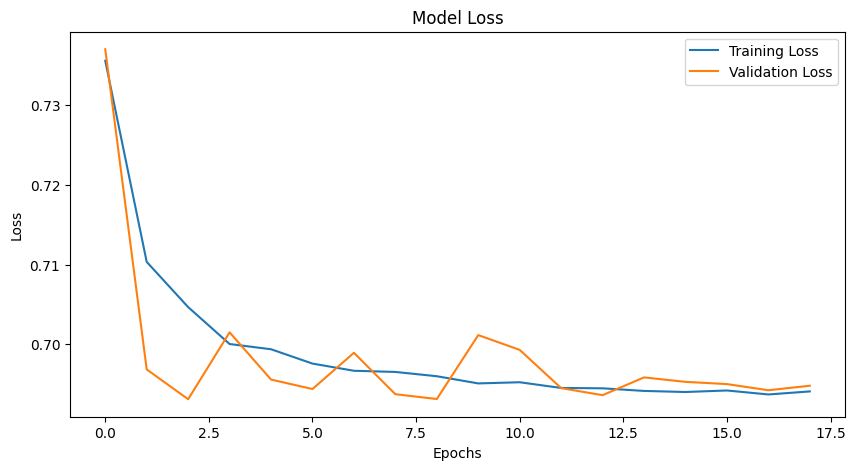

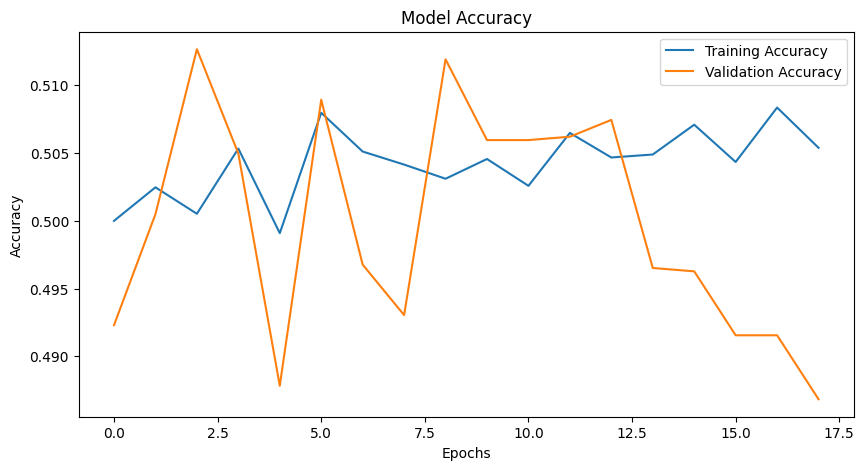

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.4937
              precision    recall  f1-score   support

           0       0.50      0.07      0.13      5115
           1       0.49      0.93      0.64      4973

    accuracy                           0.49     10088
   macro avg       0.50      0.50      0.38     10088
weighted avg       0.50      0.49      0.38     10088

ROC-AUC Score: 0.4918


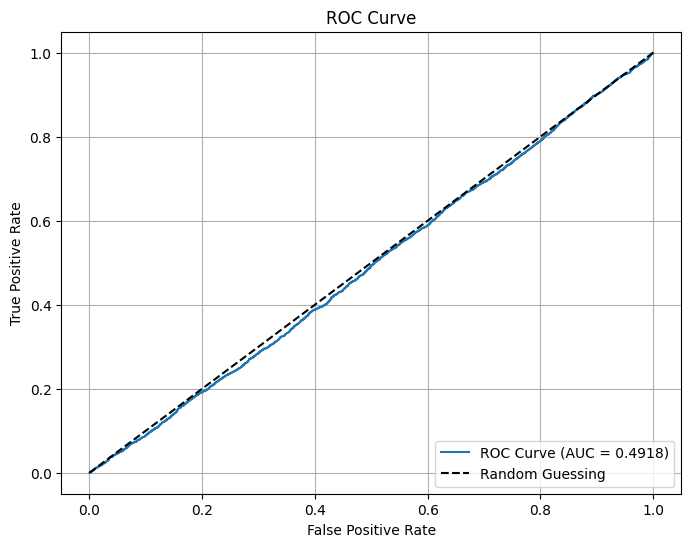

In [7]:

# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model_simplified.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

I will analyze my best-performing models by changing the window size.

In [40]:
# Zaman penceresi boyutu
window_size = 20

# Eğitim ve test verilerini zaman serisi formatına dönüştürme
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, window_size)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, window_size)


In [41]:
# Modeli yeniden tanımlama (basitleştirilmiş yapı)
model_simplified = Sequential()

# Block 1
model_simplified.add(Conv1D(filters=64, kernel_size=3, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model_simplified.add(BatchNormalization())
model_simplified.add(ReLU())
model_simplified.add(Dropout(0.3)) 

# Block 2
model_simplified.add(Conv1D(filters=32, kernel_size=3))
model_simplified.add(BatchNormalization())
model_simplified.add(ReLU())
model_simplified.add(Dropout(0.3))

# Block 3
model_simplified.add(Conv1D(filters=16, kernel_size=3))
model_simplified.add(BatchNormalization())
model_simplified.add(ReLU())
model_simplified.add(Dropout(0.3))

# LSTM Layer
model_simplified.add(LSTM(100, return_sequences=False))  # Daha az LSTM nöronu
model_simplified.add(BatchNormalization())

# Fully Connected Layers
model_simplified.add(Dense(100, activation='relu'))  # İlk dense katman 100 nöron
model_simplified.add(Dropout(0.3))  # Ek dropout
model_simplified.add(Dense(1, activation='sigmoid'))  # Çıkış katmanı


# Exponential Decay ile öğrenme oranı tanımlama
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,  # Başlangıç öğrenme oranı
    decay_steps=10000,            # Her 10.000 adımdan sonra
    decay_rate=0.9                # Öğrenme oranını %10 azalt
)

# Adam optimizatörüyle kullanımı
optimizer = Adam(learning_rate=lr_schedule)

# Modeli derleme
model_simplified.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# Modeli eğitme
history = model_simplified.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

# Test seti üzerinde değerlendirme
test_loss, test_accuracy = model_simplified.evaluate(X_test_seq, y_test_seq, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")



Epoch 1/100
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.4968 - loss: 0.7300 - val_accuracy: 0.5058 - val_loss: 0.6942
Epoch 2/100
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.5062 - loss: 0.6954 - val_accuracy: 0.5066 - val_loss: 0.6999
Epoch 3/100
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.5006 - loss: 0.6939 - val_accuracy: 0.5066 - val_loss: 0.6936
Epoch 4/100
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.5097 - loss: 0.6934 - val_accuracy: 0.5066 - val_loss: 0.6932
Epoch 5/100
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.5056 - loss: 0.6932 - val_accuracy: 0.5066 - val_loss: 0.6972
Epoch 6/100
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.5040 - loss: 0.6934 - val_accuracy: 0.5066 - val_loss: 0.6930
Epoch 7/100
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.5071 - loss: 0.6932 - val_accuracy: 0.5066 - val_loss: 0.6934
Epoch 8/100
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.5060 -

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_20 (Conv1D)              │ (None, 15, 64)         │         2,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_21 (ReLU)                 │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 15, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 15, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 15, 8)          │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 15, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_23 (ReLU)                 │ (None, 15, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 15, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 15, 8)          │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 15, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 15, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 15, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 15, 1)          │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 15, 1)          │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_25 (ReLU)                 │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 150)            │           600 │
│ (BatchNormalization)            │                        │             

 Total params: 396,392 (1.51 MB)

 Trainable params: 197,932 (773.17 KB)

 Non-trainable params: 526 (2.05 KB)

 Optimizer params: 197,934 (773.18 KB)

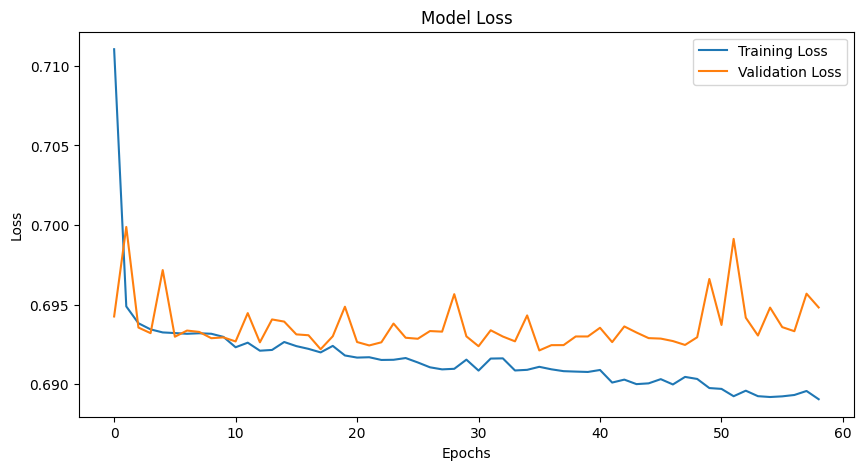

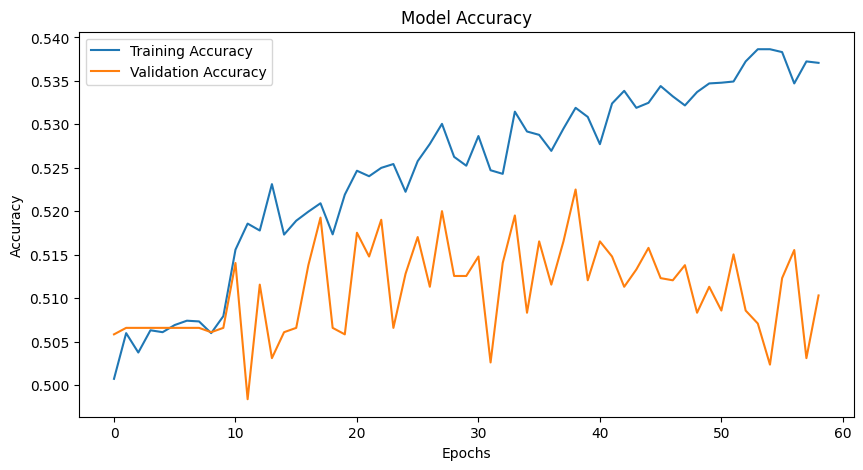

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 0.5072
              precision    recall  f1-score   support

           0       0.55      0.16      0.24      5112
           1       0.50      0.87      0.63      4971

    accuracy                           0.51     10083
   macro avg       0.52      0.51      0.44     10083
weighted avg       0.52      0.51      0.44     10083

ROC-AUC Score: 0.5227


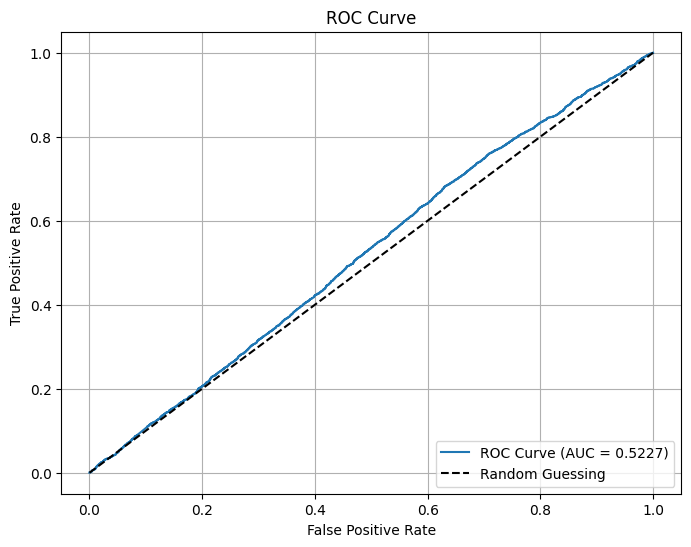

In [42]:
model_simplified.summary()

# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model_simplified.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [43]:
# Sequential Model
model = Sequential()

# Block 1
model.add(Conv1D(filters=64, kernel_size=1, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.25))

# Block 2
model.add(Conv1D(filters=32, kernel_size=1))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.25))

# Block 3 (repeated twice)
for _ in range(2):
    model.add(Conv1D(filters=8, kernel_size=1))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.25))

# Block 4
model.add(Conv1D(filters=1, kernel_size=1))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.25))

# LSTM Layer
model.add(LSTM(150, return_sequences=False))
model.add(BatchNormalization())
model.add(ReLU())

# Fully Connected Layers
model.add(Dense(200, activation='relu'))
for _ in range(6):
    model.add(Dense(100, activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)
# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5079 - loss: 0.6932 - val_accuracy: 0.5066 - val_loss: 0.6932
Epoch 2/100
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.5119 - loss: 0.6926 - val_accuracy: 0.5066 - val_loss: 0.6933
Epoch 3/100
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.5115 - loss: 0.6930 - val_accuracy: 0.5066 - val_loss: 0.6931
Epoch 4/100
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.5047 - loss: 0.6931 - val_accuracy: 0.5066 - val_loss: 0.6933
Epoch 5/100
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.5084 - loss: 0.6931 - val_accuracy: 0.5066 - val_loss: 0.6931
Epoch 6/100
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.5045 - loss: 0.6932 - val_accuracy: 0.5066 - val_loss: 0.6931
Epoch 7/100
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.5063 - loss: 0.6931 - val_accuracy: 0.5066 - val_loss: 0.6933
Epoch 8/100
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_43 (Conv1D)              │ (None, 20, 64)         │         2,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_44 (ReLU)                 │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_44 (Conv1D)              │ (None, 20, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 20, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_45 (ReLU)                 │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_45 (Conv1D)              │ (None, 20, 8)          │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 20, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_46 (ReLU)                 │ (None, 20, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 20, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_46 (Conv1D)              │ (None, 20, 8)          │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 20, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_47 (ReLU)                 │ (None, 20, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 20, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (None, 20, 1)          │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 20, 1)          │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_48 (ReLU)                 │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 150)            │           600 │
│ (BatchNormalization)            │                        │             

 Total params: 594,324 (2.27 MB)

 Trainable params: 197,932 (773.17 KB)

 Non-trainable params: 526 (2.05 KB)

 Optimizer params: 395,866 (1.51 MB)

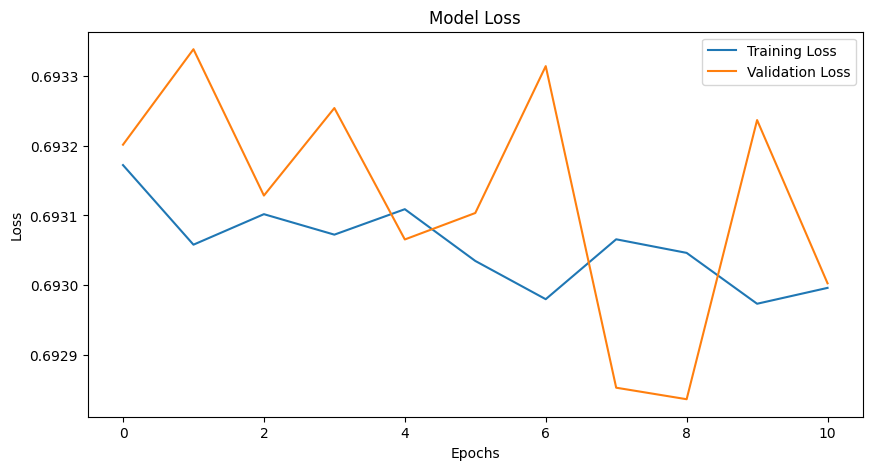

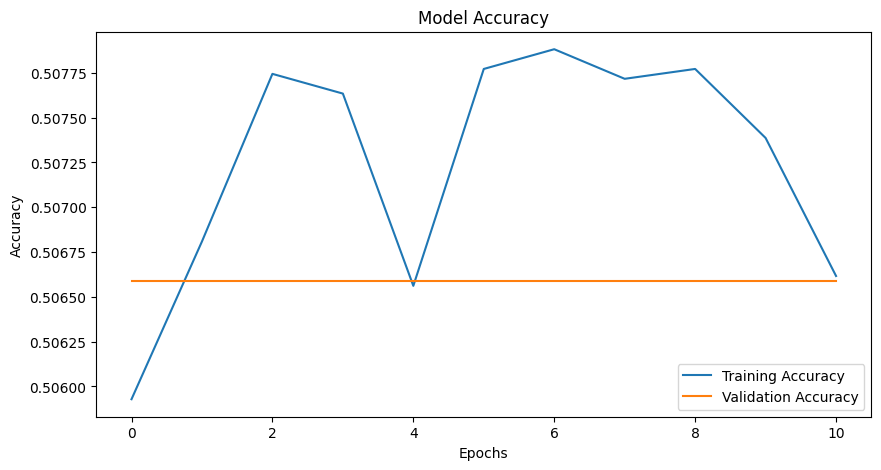

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Accuracy: 0.4930
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5112
           1       0.49      1.00      0.66      4971

    accuracy                           0.49     10083
   macro avg       0.25      0.50      0.33     10083
weighted avg       0.24      0.49      0.33     10083

ROC-AUC Score: 0.5116


c:\Users\sehsa\ETH\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sehsa\ETH\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sehsa\ETH\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


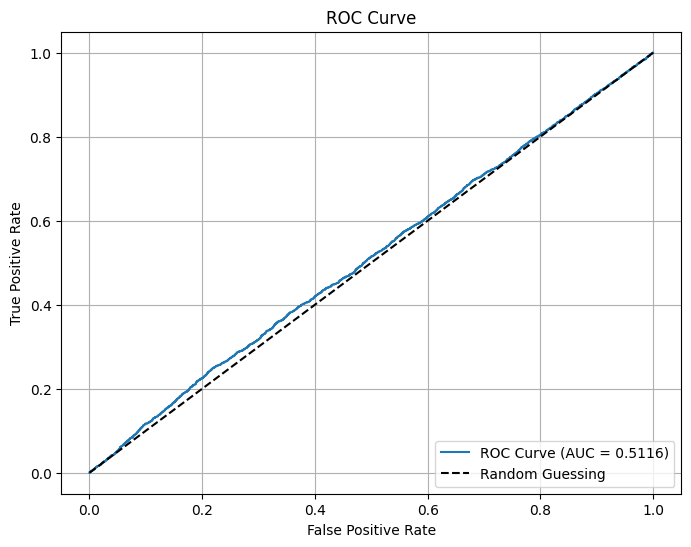

In [44]:
model.summary()

# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

As seen from the results, when the window size increased, my model failed to learn. Now, let's try again by reducing the window size.

In [52]:
# Zaman penceresi boyutu
window_size = 5

# Eğitim ve test verilerini zaman serisi formatına dönüştürme
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, window_size)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, window_size)


In [46]:
# Modeli yeniden tanımlama (basitleştirilmiş yapı)
model_simplified = Sequential()

# Block 1
model_simplified.add(Conv1D(filters=64, kernel_size=1, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model_simplified.add(BatchNormalization())
model_simplified.add(ReLU())
model_simplified.add(Dropout(0.3)) 

# Block 2
model_simplified.add(Conv1D(filters=32, kernel_size=1))
model_simplified.add(BatchNormalization())
model_simplified.add(ReLU())
model_simplified.add(Dropout(0.3))

# Block 3
model_simplified.add(Conv1D(filters=16, kernel_size=1))
model_simplified.add(BatchNormalization())
model_simplified.add(ReLU())
model_simplified.add(Dropout(0.3))

# LSTM Layer
model_simplified.add(LSTM(100, return_sequences=False))  # Daha az LSTM nöronu
model_simplified.add(BatchNormalization())

# Fully Connected Layers
model_simplified.add(Dense(100, activation='relu'))  # İlk dense katman 100 nöron
model_simplified.add(Dropout(0.3))  # Ek dropout
model_simplified.add(Dense(1, activation='sigmoid'))  # Çıkış katmanı


# Exponential Decay ile öğrenme oranı tanımlama
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,  # Başlangıç öğrenme oranı
    decay_steps=10000,            # Her 10.000 adımdan sonra
    decay_rate=0.9                # Öğrenme oranını %10 azalt
)

# Adam optimizatörüyle kullanımı
optimizer = Adam(learning_rate=lr_schedule)

# Modeli derleme
model_simplified.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# Modeli eğitme
history = model_simplified.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

# Test seti üzerinde değerlendirme
test_loss, test_accuracy = model_simplified.evaluate(X_test_seq, y_test_seq, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")



c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.5091 - loss: 0.7320 - val_accuracy: 0.5136 - val_loss: 0.6928
Epoch 2/100
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5044 - loss: 0.6951 - val_accuracy: 0.5062 - val_loss: 0.6965
Epoch 3/100
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5102 - loss: 0.6935 - val_accuracy: 0.5062 - val_loss: 0.6931
Epoch 4/100
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.5120 - loss: 0.6930 - val_accuracy: 0.4973 - val_loss: 0.6973
Epoch 5/100
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5079 - loss: 0.6936 - val_accuracy: 0.5062 - val_loss: 0.6931
Epoch 6/100
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5188 - loss: 0.6923 - val_accuracy: 0.5062 - val_loss: 0.6931
Epoch 7/100
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5089 - loss: 0.6932 - val_accuracy: 0.5062 - val_loss: 0.6981
Epoch 8/100
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5185 -

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_48 (Conv1D)              │ (None, 5, 64)          │         2,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 5, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_50 (ReLU)                 │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 5, 32)          │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 5, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_51 (ReLU)                 │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ (None, 5, 16)          │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 5, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_52 (ReLU)                 │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 100)            │        46,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,164 (738.93 KB)

 Trainable params: 62,913 (245.75 KB)

 Non-trainable params: 424 (1.66 KB)

 Optimizer params: 125,827 (491.52 KB)

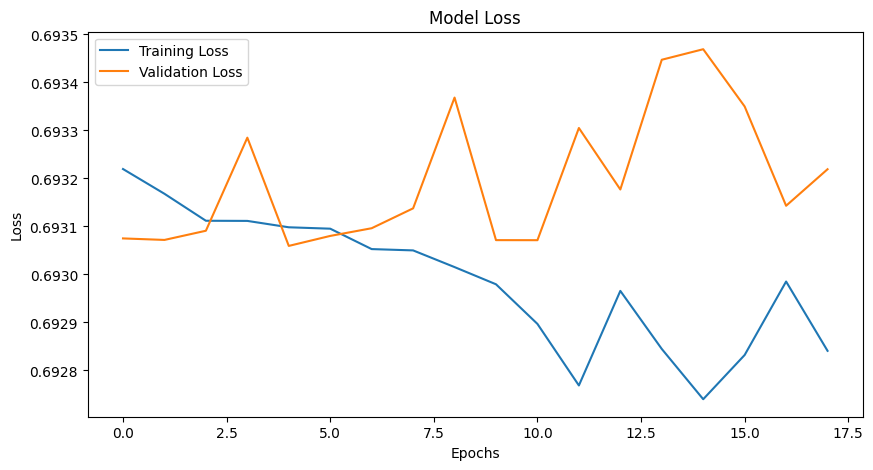

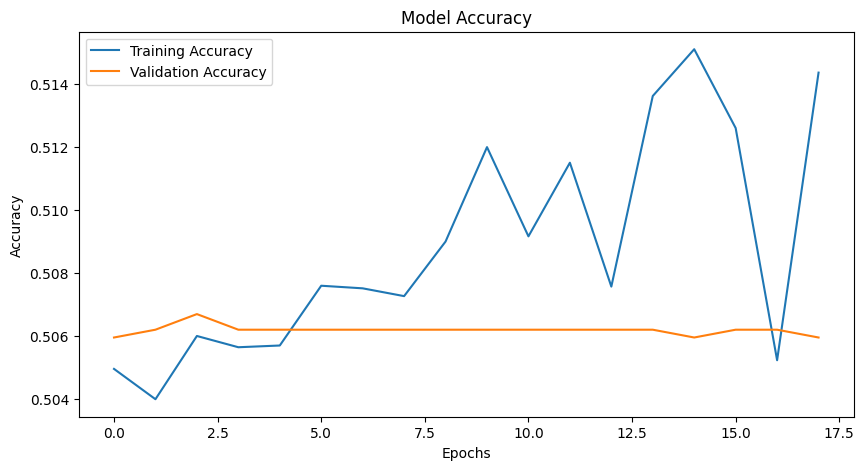

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.5196
              precision    recall  f1-score   support

           0       0.54      0.34      0.42      5122
           1       0.51      0.70      0.59      4976

    accuracy                           0.52     10098
   macro avg       0.53      0.52      0.50     10098
weighted avg       0.53      0.52      0.50     10098

ROC-AUC Score: 0.5407


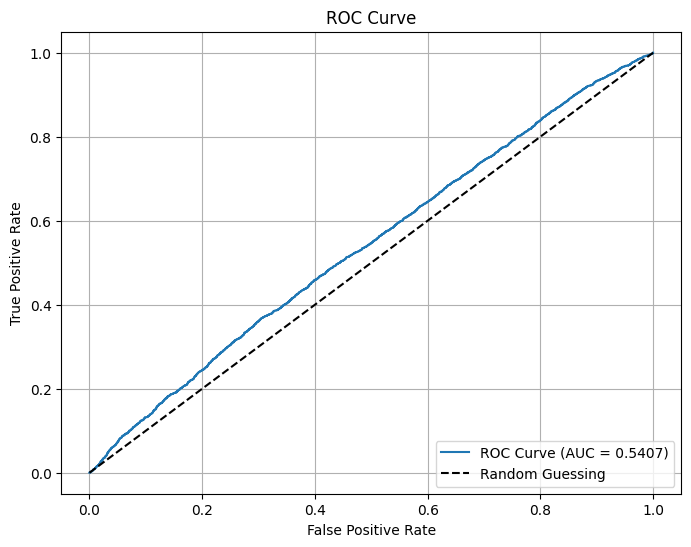

In [50]:
model_simplified.summary()

# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model_simplified.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [48]:
# Sequential Model
model = Sequential()

# Block 1
model.add(Conv1D(filters=64, kernel_size=1, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.25))

# Block 2
model.add(Conv1D(filters=32, kernel_size=1))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.25))

# Block 3 (repeated twice)
for _ in range(2):
    model.add(Conv1D(filters=8, kernel_size=1))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.25))

# Block 4
model.add(Conv1D(filters=1, kernel_size=1))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.25))

# LSTM Layer
model.add(LSTM(150, return_sequences=False))
model.add(BatchNormalization())
model.add(ReLU())

# Fully Connected Layers
model.add(Dense(200, activation='relu'))
for _ in range(6):
    model.add(Dense(100, activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)


# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)
# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.5017 - loss: 0.6933 - val_accuracy: 0.5059 - val_loss: 0.6931
Epoch 2/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5003 - loss: 0.6932 - val_accuracy: 0.5062 - val_loss: 0.6931
Epoch 3/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5115 - loss: 0.6929 - val_accuracy: 0.5067 - val_loss: 0.6931
Epoch 4/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5052 - loss: 0.6931 - val_accuracy: 0.5062 - val_loss: 0.6933
Epoch 5/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5111 - loss: 0.6929 - val_accuracy: 0.5062 - val_loss: 0.6931
Epoch 6/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5073 - loss: 0.6931 - val_accuracy: 0.5062 - val_loss: 0.6931
Epoch 7/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5102 - loss: 0.6929 - val_accuracy: 0.5062 - val_loss: 0.6931
Epoch 8/100
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5068 - loss: 

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_51 (Conv1D)              │ (None, 5, 64)          │         2,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 5, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_53 (ReLU)                 │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_52 (Conv1D)              │ (None, 5, 32)          │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 5, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_54 (ReLU)                 │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_53 (Conv1D)              │ (None, 5, 8)           │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 5, 8)           │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_55 (ReLU)                 │ (None, 5, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 5, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_54 (Conv1D)              │ (None, 5, 8)           │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 5, 8)           │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_56 (ReLU)                 │ (None, 5, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 5, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_55 (Conv1D)              │ (None, 5, 1)           │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 5, 1)           │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_57 (ReLU)                 │ (None, 5, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 5, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 150)            │           600 │
│ (BatchNormalization)            │                        │             

 Total params: 594,324 (2.27 MB)

 Trainable params: 197,932 (773.17 KB)

 Non-trainable params: 526 (2.05 KB)

 Optimizer params: 395,866 (1.51 MB)

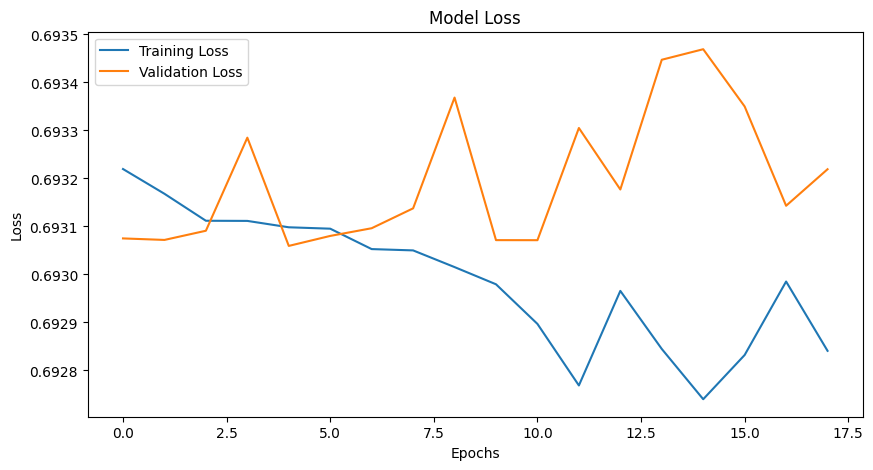

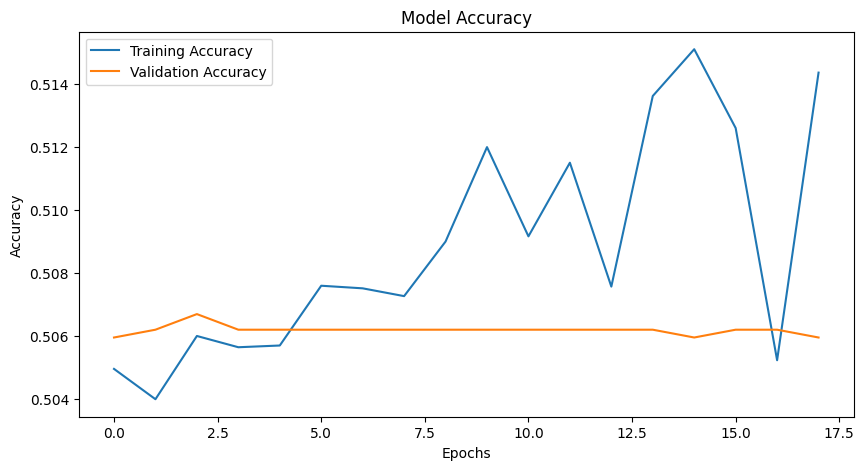

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.4946
              precision    recall  f1-score   support

           0       0.53      0.03      0.05      5122
           1       0.49      0.97      0.66      4976

    accuracy                           0.49     10098
   macro avg       0.51      0.50      0.35     10098
weighted avg       0.51      0.49      0.35     10098

ROC-AUC Score: 0.4945


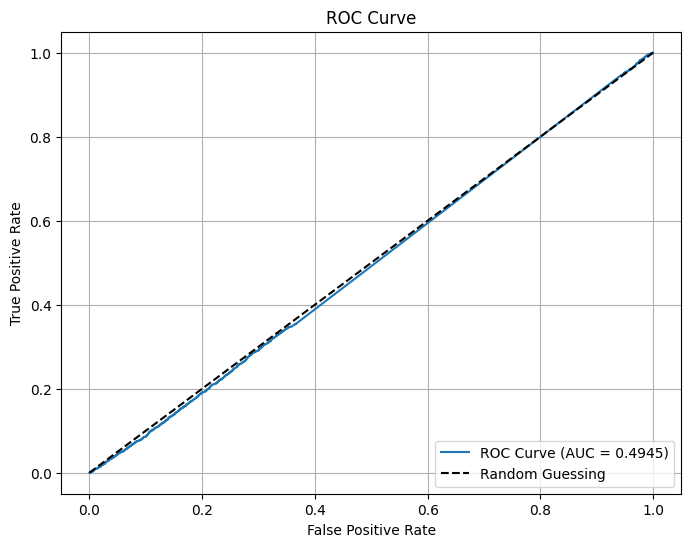

In [49]:
model.summary()

# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Modelinizi eğitip y_test_seq üzerinde tahmin yaptığınızı varsayıyoruz
y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()